# 3D MT forward modelling

## Learning goals

- Understand **spatial features** of six different components of the transfer function measured: Zxx, Zxy, Zyy, Zyx, Tzx, Tzy. 
- Identify general structure of SimPEG forward modelling.

In [1]:
import discretize
from SimPEG.electromagnetics import natural_source as NSEM
from SimPEG import utils
import numpy as np
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['font.size'] = 16

>> Use cython version


In [2]:
from SimPEG.electromagnetics import natural_source as NSEM

## Step 1: Discretize the domain using a 3D `Tensor` Mesh

In [3]:
# Make a mesh
hx = [(100, 9, -1.5), (100.0, 13), (100, 9, 1.5)]
hy = [(100, 9, -1.5), (100.0, 13), (100, 9, 1.5)]
hz = [(50, 10, -1.6), (50.0, 10), (50, 6, 2)]
hz = discretize.utils.mesh_utils.meshTensor(hz)
mesh = discretize.TensorMesh(
    [hx, hy, hz],
    x0=["C", "C", -hz[:20].sum()],
)
# Setup the model
sig_block = 1
sig_background = 1e-2
conds = [sig_block, sig_background]
sig = utils.model_builder.defineBlock(
    mesh.gridCC, [-100, -300, -350], [100, 300, -150], conds
)
sig[mesh.gridCC[:, 2] > 0] = 1e-8
sig[mesh.gridCC[:, 2] < -1000] = 1e-1
sigBG = np.ones(mesh.nC) * sig_background
sigBG[mesh.gridCC[:, 2] > 0] = 1e-8
block_x = np.r_[-100, 100, 100, -100, -100]
block_y = np.r_[-300, -300, 300, 300, -300]

Text(0.5, 1.0, '')

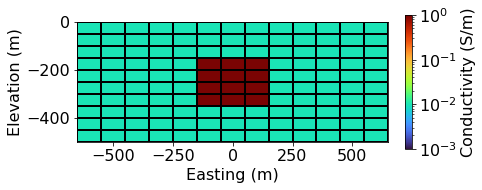

In [4]:
collect_obj = mesh.plotSlice(sig, grid=True, normal="Y", pcolor_opts={'norm': LogNorm(vmin=1e-3, vmax=1), 'cmap':'turbo'})[0]
cb = plt.colorbar(collect_obj, fraction=0.02)
cb.set_label("Conductivity (S/m)")
plt.xlim(-650, 650)
plt.ylim(-500, 0)
plt.gca().set_aspect(1)
plt.xlabel("Easting (m)")
plt.ylabel("Elevation (m)")
plt.title("")

Text(0.5, 1.0, '')

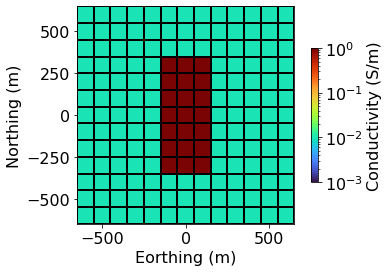

In [5]:
collect_obj = mesh.plotSlice(sig, grid=True, normal="Z", pcolor_opts={'norm': LogNorm(vmin=1e-3, vmax=1), 'cmap':'turbo'})[0]
cb = plt.colorbar(collect_obj, fraction=0.02)
plt.xlim(-650, 650)
plt.ylim(-650, 650)
plt.gca().set_aspect(1)
plt.xlabel("Eorthing (m)")
plt.ylabel("Northing (m)")
cb.set_label("Conductivity (S/m)")
plt.title("")

## Step 2: Setup a `Survey` 

In [6]:
# Setup the the survey object
# Receiver locations
rx_x, rx_y = np.meshgrid(np.arange(-600, 601, 100), np.arange(-600, 601, 100))
rx_loc = np.hstack(
    (utils.mkvc(rx_x, 2), utils.mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1)))
)

# frequencies = np.logspace(4, -2, 13)
frequencies = [1]

# Make a receiver list
rxList = []
for rx_orientation in ["xx", "xy", "yx", "yy"]:
    rxList.append(NSEM.Rx.PointNaturalSource(rx_loc, rx_orientation, "real"))
    rxList.append(NSEM.Rx.PointNaturalSource(rx_loc, rx_orientation, "imag"))
    
for rx_orientation in ["zx", "zy"]:

    # added ztem flag
    rx_real = NSEM.Rx.Point3DTipper(rx_loc, rx_orientation, "real")
    rx_imag = NSEM.Rx.Point3DTipper(rx_loc, rx_orientation, "imag")
    rxList.append(rx_real)
    rxList.append(rx_imag)

# Source list
srcList = [
    NSEM.Src.Planewave_xy_1Dprimary(rxList, freq) for freq in frequencies
]
# Survey MT
survey = NSEM.Survey(srcList)

## Step 3: Setup a 3D MT `Simulation` and run forward modelling

In [7]:
from SimPEG import maps

In [8]:
%%time
# Setup the simulation object
simulation = NSEM.Simulation3DPrimarySecondary(
    mesh, survey=survey, solver=Solver, sigma=sig, sigmaPrimary=sigBG
)

f = simulation.fields()
dpred = simulation.dpred(f=f)

Wall time: 7.26 s


## Step 4: Explore transfer functions

In [9]:
n_freq = len(frequencies)
n_rx = rx_loc.shape[0]

In [10]:
z_xx_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,0]
z_xx_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,1]
z_xy_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,2]
z_xy_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,3]
z_yx_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,4]
z_yx_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,5]
z_yy_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,6]
z_yy_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,7]
t_zx_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,8]
t_zx_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,9]
t_zy_r = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,10]
t_zy_i = dpred.reshape((n_freq, n_rx, len(rxList)), order='F')[:, :,11]

- zxx --> zyy
- zxy --> zyx
- zyx --> zxy
- zyy --> zyy
- tzx --> -tzy
- tzy --> -tzx

In [11]:
mt_data={
    "z_xy_r": z_yx_r.copy(),
    "z_xy_i": z_yx_i.copy(),
    "z_yx_r": z_xy_r.copy(),
    "z_yx_i": z_xy_i.copy(),
    "z_xx_r": z_yy_r.copy(),
    "z_xx_i": z_yy_i.copy(),
    "z_yy_r": z_xx_r.copy(),
    "z_yy_i": z_xx_i.copy(),
    "t_zx_r": -t_zy_r.copy(),
    "t_zx_i": -t_zy_i.copy(),
    "t_zy_r": -t_zx_r.copy(),
    "t_zy_i": -t_zx_i.copy(),
}
names_real = list(mt_data.keys())[::2]
names_imag = list(mt_data.keys())[1::2]

In [12]:
from ipywidgets import widgets, interact
def foo_transfer(name):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    out = utils.plot2Ddata(rx_loc[:,:2], mt_data[name].flatten(), ax=ax, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    ax.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out[0], fraction=0.03)
    ax.set_title(name)
    ax.set_xlabel('Y (m)')
    ax.set_ylabel('X (m)')

In [13]:
Q = interact(foo_transfer, name=widgets.Select(options=names_real))

interactive(children=(Select(description='name', options=('z_xy_r', 'z_yx_r', 'z_xx_r', 'z_yy_r', 't_zx_r', 't…

## Step 5: Explore E and H fields

In [14]:
# Get e and h fields
e = f[srcList[0], 'e']
h = f[srcList[0], 'h']

# Generate interpolation matricies
Pex = mesh.get_interpolation_matrix(rx_loc, location_type='edges_x')
Pey = mesh.get_interpolation_matrix(rx_loc, location_type='edges_y')
Pfx = mesh.get_interpolation_matrix(rx_loc, location_type='faces_x')
Pfy = mesh.get_interpolation_matrix(rx_loc, location_type='faces_y')
Pfz = mesh.get_interpolation_matrix(rx_loc, location_type='faces_z')

# Interpolate onto receiver locations
ex = Pex * e
ey = Pey * e
hx = Pfx * h
hy = Pfy * h
hz = Pfz * h

ex_tr = ey.copy()
ey_tr = ex.copy()

hx_tr = hy.copy()
hy_tr = hx.copy()
hz_tr = -hz.copy()

mt_eh_data={
    "ex_jy": ex_tr[:,0].copy(),
    "ex_jx": ex_tr[:,1].copy(),
    "ey_jy": ey_tr[:,0].copy(),
    "ey_jx": ey_tr[:,1].copy(),
    "hx_jy": hx_tr[:,0].copy(),
    "hx_jx": hx_tr[:,1].copy(),
    "hy_jy": hy_tr[:,0].copy(),
    "hy_jx": hy_tr[:,1].copy(),
    "hz_jy": hz_tr[:,0].copy(),
    "hz_jx": hz_tr[:,1].copy(),
}
names_eh = list(mt_eh_data.keys())

In [15]:
def foo_eh(name):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    out = utils.plot2Ddata(rx_loc[:,:2], mt_eh_data[name].real.flatten(), ax=ax, dataloc=True, ncontour=20, contourOpts={'cmap':'turbo'})
    ax.plot(block_x, block_y, color='k', lw=4)
    plt.colorbar(out[0], fraction=0.03)
    ax.set_title(name)
    ax.set_xlabel('Y (m)')
    ax.set_ylabel('X (m)')

In [16]:
Q = interact(foo_eh, name=widgets.Select(options=names_eh))

interactive(children=(Select(description='name', options=('ex_jy', 'ex_jx', 'ey_jy', 'ey_jx', 'hx_jy', 'hx_jx'…